In [ ]:
import numpy as np
from scipy.integrate import quad

def rv_pmode_residual_rms(exptimes,
                          teff, logg, mstar, rstar,
                          readtime=0.0, nobs=1,
                          method='chaplin', nmodes=13,
                          # Solar reference values
                          nu_max_sun=3100.0, delta_nu_sun=134.9,
                          a_max_sun=0.19, c_env_sun=331.0,
                          logg_sun=4.44, teff_sun=5777.0,
                          S=(1.0, 1.35, 1.02, 0.47)):
    """
    Return p-mode residual RV RMS (m/s) as a function of exposure time.

    Parameters
    ----------
    exptimes : float or array-like
        Exposure time(s) in seconds (single value or list/array).
    teff, logg : float
        Effective temperature (K) and log10 surface gravity (cgs) of the star.
    mstar, rstar : float
        Stellar mass and radius in solar units.
    readtime : float, default 0
        Readout (dead) time between sub-exposures (s). Set >0 with nobs>1 to use Gupta et al. (2022) sequence transfer function.
    nobs : int, default 1
        Number of identical sub-exposures. If 1, treated as a single continuous integration.
    method : {'chaplin','comb'}, default 'chaplin'
        'chaplin' integrates over a Gaussian power envelope (Chaplin et al. 2019).
        'comb' approximates discrete modes (simple spacing assumptions; approximate).
    nmodes : int, default 13
        Number of radial orders (per l ridge) in comb approximation (odd number recommended).
    S : 4-tuple
        Spatial response factors (l=0..3).

    Returns
    -------
    residual_rms : ndarray or float
        Residual p-mode RMS velocity (m/s) after temporal averaging for each exposure time.
        Returns a float if input exptimes was scalar.
    """

    # Make array
    scalar_input = np.isscalar(exptimes)
    exptimes = np.atleast_1d(exptimes).astype(float)

    # --- Scaling relations (Chaplin et al. 2019) ---
    nu_max = nu_max_sun * 10.0**(logg - logg_sun) / np.sqrt(teff / teff_sun)
    a_max = a_max_sun * (teff / teff_sun)**4 / 10.0**(logg - logg_sun)
    if teff < teff_sun:
        c_env = c_env_sun * (nu_max / nu_max_sun)**0.88
    else:
        c_env = c_env_sun * (nu_max / nu_max_sun)**0.88 * (1.0 + (teff - teff_sun)/1667.0)
    delta_nu = delta_nu_sun * np.sqrt(mstar / rstar**3)

    S = np.array(S, dtype=float)
    S2_sum = np.sum(S**2)

    def delta_nu_func():
        return delta_nu

    # --- Transfer function ---
    def transfer_eta(nu_microHz, exptime_sec):
        if readtime == 0 or nobs == 1:
            # Continuous exposure: eta = sinc(nu / nu_exp), nu_exp = 1e6 / t
            nu_exp = 1e6 / exptime_sec
            return np.abs(np.sinc(nu_microHz / nu_exp))
        else:
            # Sequence (Gupta et al. 2022, Eq. 23)
            exptime = exptime_sec
            f = nu_microHz * 1e-6  # Hz
            m_idx = np.arange(nobs)
            phase = (2*m_idx - nobs + 1) * np.pi * f[:, None]
            eta_c = np.exp(phase * exptime * 1j) * np.exp(phase * readtime * 1j)
            eta_c_sum = np.sum(eta_c, axis=1).real
            with np.errstate(divide='ignore', invalid='ignore'):
                pref = np.sin(np.pi * f * exptime) / (np.pi * f * (exptime * nobs))
            pref[f == 0.0] = 1.0 / nobs
            return pref * np.abs(eta_c_sum)

    # --- Power spectral density envelope ---
    def envelope_power(nu_microHz):
        return a_max**2 * S2_sum * np.exp(-0.5 * (nu_microHz - nu_max)**2 / c_env**2)

    # --- Integrand for Chaplin method: (eta^2 * P_env) / delta_nu ---
    def integrand_chaplin(nu_microHz, nu_exp, exptime_sec):
        eta = transfer_eta(np.array([nu_microHz]), exptime_sec)[0]
          # P_env
        p = envelope_power(nu_microHz)
        return (eta**2 * p) / delta_nu_func()

    # --- Discrete comb (approximate) ---
    def comb_integral(exptime_sec):
        # Build mode centers (approximate small separations)
        n_indices = np.arange(-nmodes//2, nmodes//2 + 1)
        nu_n = nu_max + n_indices * delta_nu
        d01 = 0.5 * delta_nu
        eps = delta_nu / 10.0  # crude small spacing
        nu_l0 = nu_n[:-1] + d01
        nu_l1 = nu_n
        nu_l2 = nu_n[:-1] + d01 - eps
        nu_l3 = nu_n - eps
        sets = [nu_l0, nu_l1, nu_l2, nu_l3]
        weights = S**2 / S2_sum
        integral = 0.0
        for lset, w in zip(sets, weights):
            if len(lset) == 0:
                continue
            eta = transfer_eta(lset, exptime_sec)
            p = a_max**2 * np.exp(-0.5 * (lset - nu_max)**2 / c_env**2)
            # Each mode contributes eta^2 * p * delta_nu * w
            integral += np.sum(eta**2 * p * delta_nu * w)
        return integral

    residuals = np.empty_like(exptimes)
    # Pre-compute integration bounds for chaplin
    # ±N * c_env around nu_max; N=~(nu_max/c_env -3) in original code; simpler: 6 * c_env span
    N_span = 6.0
    nu_min = max(0.0, nu_max - N_span * c_env)
    nu_max_lim = nu_max + N_span * c_env

    for i, texp in enumerate(exptimes):
        if method == 'chaplin':
            # Integrate envelope * filter
            integral_val = quad(integrand_chaplin, nu_min, nu_max_lim,
                                args=(1e6/texp, texp), limit=200)[0]
        elif method == 'comb':
            integral_val = comb_integral(texp)
        else:
            raise ValueError("method must be 'chaplin' or 'comb'")
        residuals[i] = np.sqrt(integral_val)

    if scalar_input:
        return float(residuals[0])
    return residuals

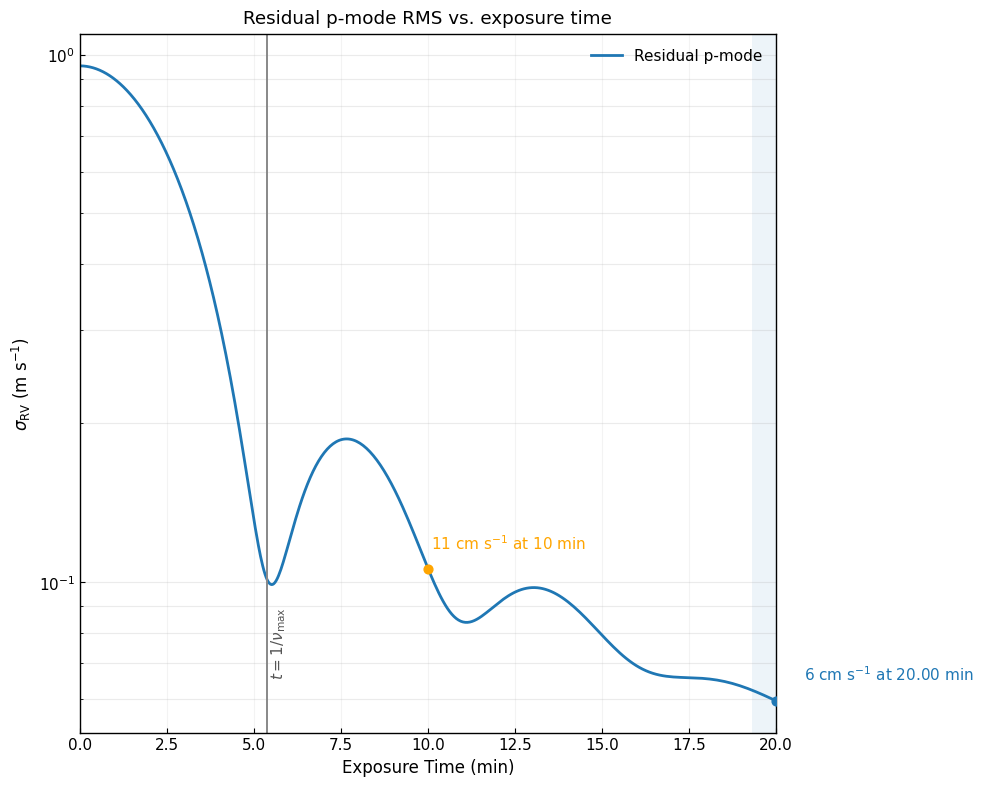

In [13]:
import matplotlib.pyplot as plt
# from p_mode_residual_curve import rv_pmode_residual_rms

# ----------------------------
# Stellar (Sun-like)
# ----------------------------
teff  = 5777.0
logg  = 4.44
mstar = 1.0
rstar = 1.0

# Exposure grid: extend to 20 min to match figure aesthetic
exptimes = np.logspace(0, np.log10(20*60), 1200)  # 1 s to 1200 s (20 min)

# P-mode residuals (m/s)
rms = rv_pmode_residual_rms(exptimes, teff, logg, mstar, rstar)

# ν_max (μHz) and characteristic timescale
nu_max_sun = 3100.0  # μHz
nu_max = nu_max_sun * 10**(logg - 4.44) / np.sqrt(teff / 5777.0)  # μHz
t_vmax_sec = 1.0 / (nu_max * 1e-6)         # seconds
t_vmax_min = t_vmax_sec / 60.0

# ----------------------------
# Identify trough AFTER t_vmax
# ----------------------------
mask_after = exptimes >= t_vmax_sec
if mask_after.any():
    idx_local = np.argmin(rms[mask_after])
    exptime_trough_sec = exptimes[mask_after][idx_local]
    rms_trough = rms[mask_after][idx_local]
else:
    exptime_trough_sec = exptimes[np.argmin(rms)]
    rms_trough = rms.min()
exptime_trough_min = exptime_trough_sec / 60.0

# Define a "near-optimal" region: where residual ≤ 1.05 * trough value and t ≥ t_vmax
optimal_mask = (exptimes >= t_vmax_sec) & (rms <= 1.05 * rms_trough)
# Contiguous region bounds (if any)
if optimal_mask.any():
    opt_inds = np.where(optimal_mask)[0]
    opt_start = exptimes[opt_inds[0]] / 60.0
    opt_end   = exptimes[opt_inds[-1]] / 60.0
else:
    opt_start = opt_end = None

# ----------------------------
# Plot styling
# ----------------------------
plt.rcParams.update({
    "axes.linewidth": 1.0,
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": False
})

fig, ax = plt.subplots(figsize=(10, 8))

# P-mode residual curve
ax.plot(exptimes/60.0, rms, color='#1f77b4', lw=2.0, label='Residual p-mode')

# Vertical line at t = 1/ν_max
ax.axvline(t_vmax_min, color='#888888', lw=1.4)
ax.text(t_vmax_min*1.015,
        rms.min()*1.10,
        r'$t = 1/\nu_{\max}$',
        rotation=90, va='bottom', ha='left', color='#555555')

# Shaded optimal band (optional)
if opt_start is not None and opt_end > opt_start:
    ax.axvspan(opt_start, opt_end, color='#1f77b4', alpha=0.08, lw=0)

# Trough marker
ax.scatter([exptime_trough_min], [rms_trough], color='#1f77b4', s=40, zorder=5)
ax.text(exptime_trough_min*1.04,
        rms_trough*1.08,
        f"{rms_trough*100:.0f} cm s$^{{-1}}$ at {exptime_trough_min:.2f} min",
        color='#1f77b4', ha='left', va='bottom')

# --- Label RMS at 10 minutes ---
exptime_10min = 10.0  # minutes
# Find the closest exptime to 10 min
idx_10min = np.abs(exptimes/60.0 - exptime_10min).argmin()
rms_10min = rms[idx_10min]
ax.scatter([exptime_10min], [rms_10min], color='orange', s=40, zorder=6)
ax.text(exptime_10min*1.01,
        rms_10min*1.08,
        f"{rms_10min*100:.0f} cm s$^{{-1}}$ at 10 min",
        color='orange', ha='left', va='bottom')

# Axes
ax.set_xlim(0, 20)
ax.set_xlabel('Exposure Time (min)')
ax.set_ylabel(r'$\sigma_{\mathrm{RV}}$ (m s$^{-1}$)')
ax.set_yscale('log')
ax.set_title('Residual p-mode RMS vs. exposure time', pad=8)

# Light grid
ax.grid(which='both', axis='y', alpha=0.25)
ax.grid(which='major', axis='x', alpha=0.15)

# Legend
ax.legend(frameon=False, loc='upper right')


fig.tight_layout()
plt.show()